# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

NUM_SPLITS = 10

trn_splits = [None] * NUM_SPLITS
tst_splits = [None] * NUM_SPLITS
    
for spli in range(NUM_SPLITS):  
    trn_splits[spli] = pd.read_csv('data/prepared_mm_fe/%d.csv' % spli, sep=';')
    tst_splits[spli] = pd.read_csv('data/prepared_fe_test/%d.csv' % spli, sep=';')
    
    for feature in tst_splits[spli].columns:
        if feature not in trn_splits[spli].columns:
            tst_splits[spli] = tst_splits[spli].drop(feature, axis=1)

## 3.5. Gradient Boosting

---

### Run algorithm

---

<Figure size 600x450 with 0 Axes>

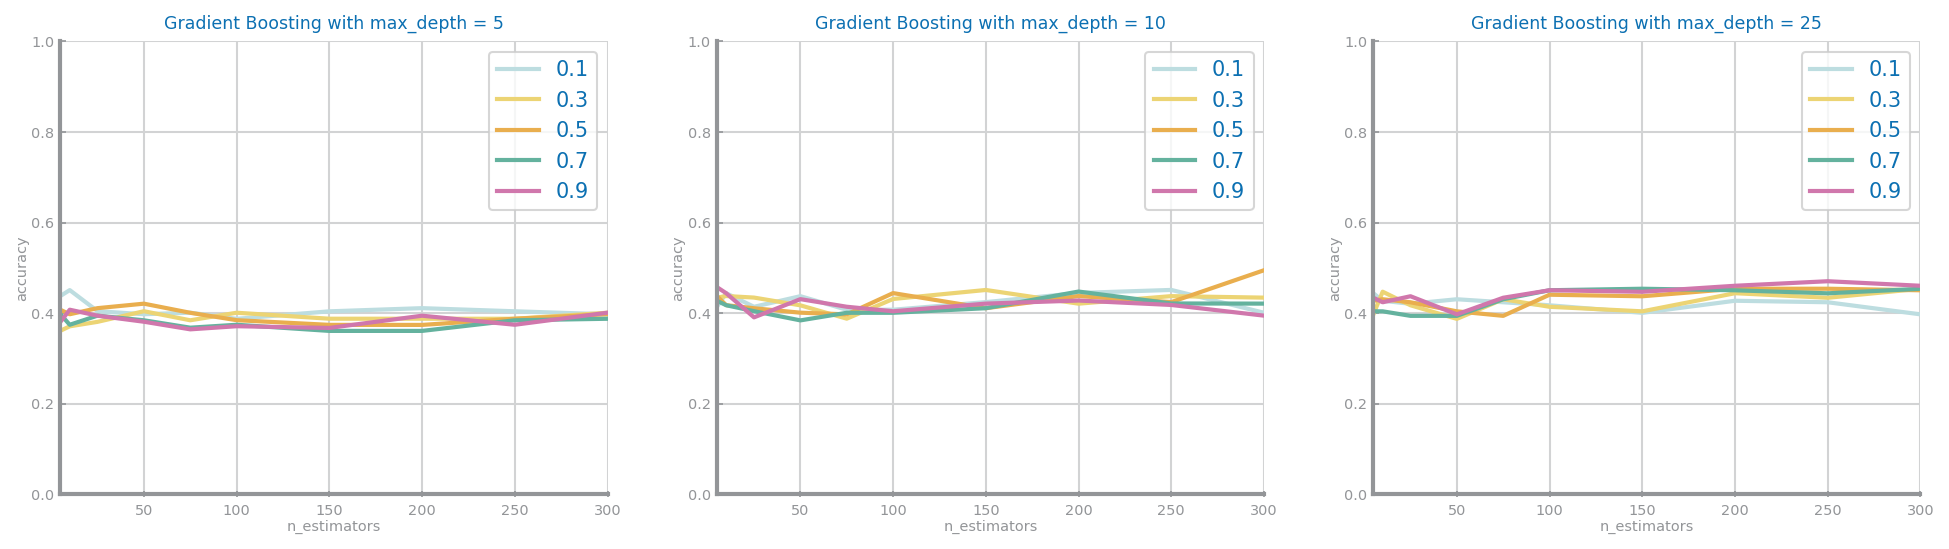

Best results per split:
	Split 0: depth=5, learning_rate=0.500000 and n_estimators=5 ==> accuracy=0.40
	Split 1: depth=5, learning_rate=0.100000 and n_estimators=10 ==> accuracy=0.53
	Split 2: depth=5, learning_rate=0.100000 and n_estimators=150 ==> accuracy=0.73
	Split 3: depth=10, learning_rate=0.300000 and n_estimators=250 ==> accuracy=0.43
	Split 4: depth=5, learning_rate=0.700000 and n_estimators=5 ==> accuracy=0.50
	Split 5: depth=5, learning_rate=0.900000 and n_estimators=10 ==> accuracy=0.60
	Split 6: depth=10, learning_rate=0.700000 and n_estimators=150 ==> accuracy=0.73
	Split 7: depth=10, learning_rate=0.700000 and n_estimators=300 ==> accuracy=0.50
	Split 8: depth=25, learning_rate=0.700000 and n_estimators=300 ==> accuracy=0.67
	Split 9: depth=10, learning_rate=0.500000 and n_estimators=300 ==> accuracy=0.45


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

labels = [False, True]
target = 'DEATH_EVENT'

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]

cols = len(max_depths)

split_best = [(0, .0, 0)] * NUM_SPLITS
split_best_gb = [None] * NUM_SPLITS
split_last_best = [0] * NUM_SPLITS

# Create lists for (trnY, trnX, tstY, tstX) for each split
trnY, trnX, tstY, tstX = [], [], [], []
for spli in range(NUM_SPLITS):    
    trnY.append(trn_splits[spli].pop(target).values)
    trnX.append(trn_splits[spli].values)
    tstY.append(tst_splits[spli].pop(target).values)
    tstX.append(tst_splits[spli].values)

# Run algorithm and plot results
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(16, 4), squeeze=False)
for k in range(cols):
    d = max_depths[k]
    values = {}
    for lr in learning_rate:
        values[lr] = []
        for _ in range(len(n_estimators)):
            values[lr].append(0)
    for spli in range(NUM_SPLITS):
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX[spli], trnY[spli])
                prdY = gb.predict(tstX[spli])
                yvalues.append(metrics.accuracy_score(tstY[spli], prdY))
                # Check if accuracy is better than best in current split
                if yvalues[-1] > split_last_best[spli]:
                    split_best[spli] = (d, lr, n)
                    split_last_best[spli] = yvalues[-1]
                    split_best_gb[spli] = gb
            # Increment total accuracy for current (learning_rate, n_estimators)
            for n in range(len(yvalues)):
                values[lr][n] += yvalues[n]
    # Normalize
    for lr in values:
        for n in range(len(values[lr])):
            values[lr][n] /= NUM_SPLITS
            
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boosting with max_depth = %d' % d,
                           xlabel='n_estimators', ylabel='accuracy', percentage=True)
plt.show()

print('Best results per split:')
for spli in range(NUM_SPLITS):
    print('\tSplit %d: depth=%d, learning_rate=%f and n_estimators=%d ==> accuracy=%1.2f'
        % (spli, *split_best[spli], split_last_best[spli]))

### Average results

---

In [3]:
from scipy import stats

acc = 0
for spli in range(NUM_SPLITS):
    acc += split_last_best[spli]
print("Average accuracy: %1.2f" % (acc / NUM_SPLITS))

parameters = ('depth', 'learning_rate', 'n_estimators')

for p in range(len(parameters)):
    values = []
    for spli in range(NUM_SPLITS):
        values.append(split_best[spli][p])
    print("*** %s ***" % parameters[p])
    print("Mean: %1.2f" % np.mean(values))
    print("Median: %1.2f" % np.median(values))
    print("Mode: ", end="")
    print(stats.mode(values).mode)

Average accuracy: 0.55
*** depth ***
Mean: 9.00
Median: 7.50
Mode: [5]
*** learning_rate ***
Mean: 0.52
Median: 0.60
Mode: [0.7]
*** n_estimators ***
Mean: 148.00
Median: 150.00
Mode: [300]


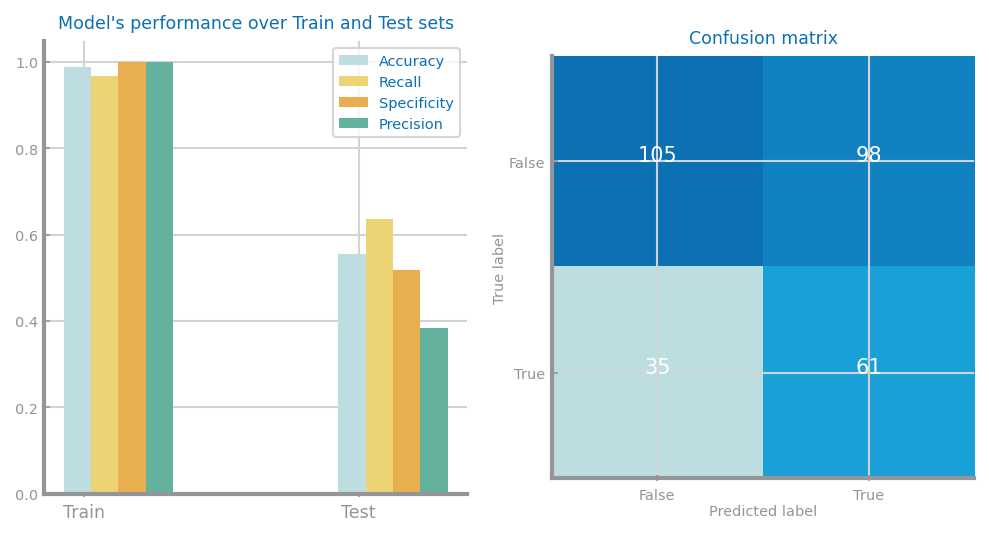

In [4]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for spli in range(NUM_SPLITS):
    y_train_all.extend(trnY[spli])
    prd_train_all.extend(split_best_gb[spli].predict(trnX[spli]))
    y_test_all.extend(tstY[spli])
    prd_test_all.extend(split_best_gb[spli].predict(tstX[spli]))
    
ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

In [5]:
mean = np.mean(split_last_best)
std = np.std(split_last_best)
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print(f'Mean value: {round(mean, 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    minAcc = mean - t_st[c] * std / (10**0.5)
    maxAcc = mean + t_st[c] * std / (10**0.5)
    print(f'{int(conf*100)}% cofidence interval for accuracy: [' +
        f'{round(minAcc, 3)},{round(maxAcc, 3)}]')

Mean value: 0.555
95% cofidence interval for accuracy: [0.488,0.621]
99% cofidence interval for accuracy: [0.453,0.656]


### Overfitting study

<Figure size 600x450 with 0 Axes>

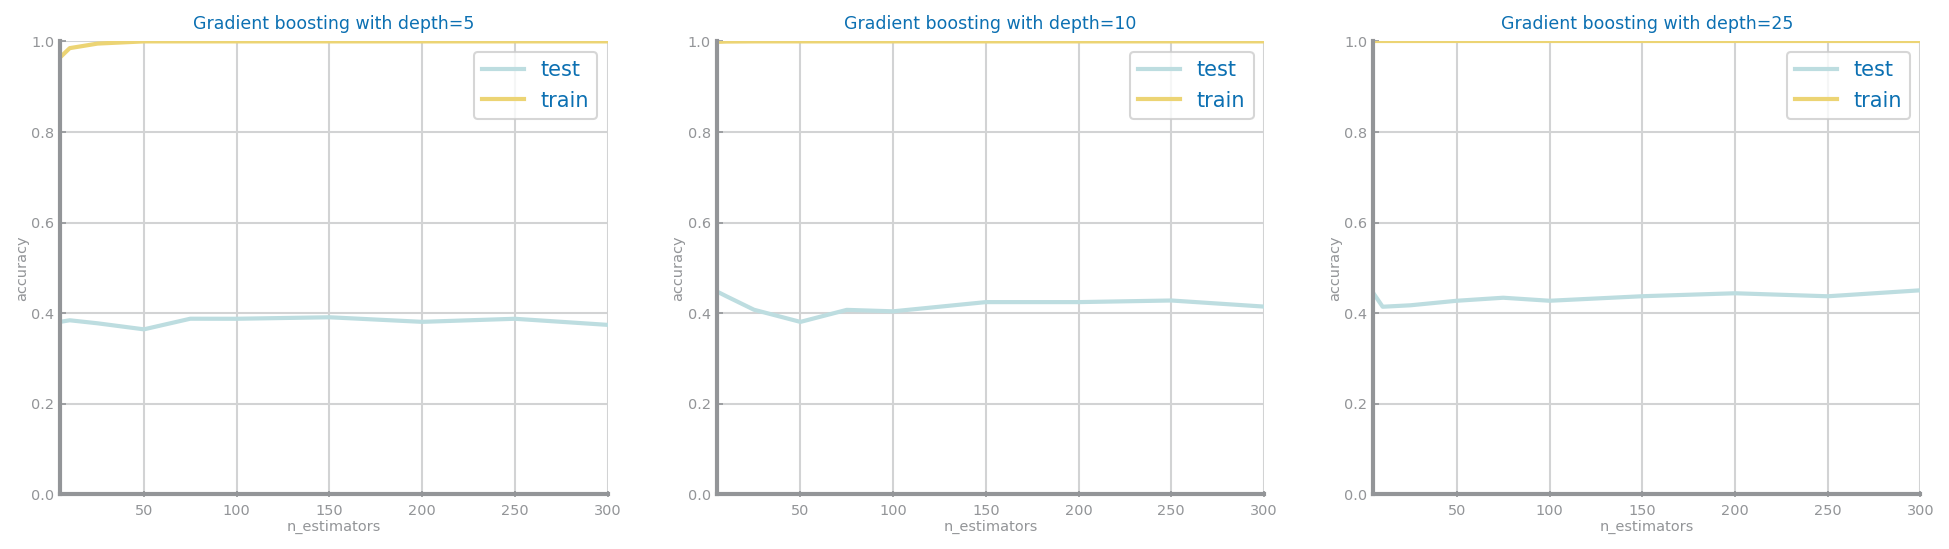

In [6]:
values = []

for k in range(len(max_depths)):
    values.append(
        {'test': [0 for _ in n_estimators], 
         'train': [0 for _ in n_estimators]})

for spli in range(NUM_SPLITS):
    lr = split_best[spli][1]

    for k in range(cols):
        d = max_depths[k]

        yvalues = []
        yvalues_train = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX[spli], trnY[spli])
            prdY = gb.predict(tstX[spli])
            prdY_train = gb.predict(trnX[spli])
            yvalues.append(metrics.accuracy_score(tstY[spli], prdY))
            yvalues_train.append(metrics.accuracy_score(trnY[spli], prdY_train))
        values[k]['test'] = [values[k]['test'][v] + 
            yvalues[v]/NUM_SPLITS for v in range(len(yvalues))]
        values[k]['train'] = [values[k]['train'][v] +
            yvalues_train[v]/NUM_SPLITS for v in range(len(yvalues_train))]

plt.figure()
fig, axs = plt.subplots(1, len(max_depths), figsize=(16, 4), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    ds.multiple_line_chart(n_estimators, values[k], ax=axs[0, k], title='Gradient boosting with depth=%d' % (d),
        xlabel='n_estimators', ylabel='accuracy', percentage=True)
plt.show()